In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import glob
import os
import csv

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


In [48]:
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

In [35]:
neurons = 512 #512                
activation_function = 'tanh'  
loss = 'mse'                  
optimizer = 'sgd'             
dropout = 0.25                
batch_size = 1#128              
epochs = 10                  
window_len = 30                     

In [25]:
def load_data():
    path =r'../Data set/FIXED_SET50/'
    allFiles = glob.glob(path + "/*.csv")
    frames = [pd.read_csv(
        f, 
        usecols=[0, 1],
        index_col=0, 
        parse_dates=True,
        header=0,
        names=['date', os.path.basename(f).split('.')[0]],
        ).round(1) for f in allFiles if "" in f]
    df = frames[0]
    for df_ in frames[1:]:
        df = df.merge(df_, how='outer', left_index=True, right_index=True)
    return df

def create_inputs(data, window_len):
    inputs = []
    for i in range(len(data) - window_len):
        temp_set = data[i:(i + window_len)].copy()
        inputs.append(temp_set)
    for col in train_set.columns:
        inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
    return inputs

def create_outputs(data,window_len):
    return (data[window_len:].values / data[:-window_len].values) - 1

def to_array(data):
    x = [np.array(data[i]) for i in range (len(data))]
    return np.array(x)

In [26]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc','mse'])
    model.summary()
    return model

In [27]:
dataset = load_data()
# dataset = dataset.dropna()

In [459]:
# dataset.isnull().sum()

In [30]:
train_set = dataset[:int(len(dataset) * 0.8)]
test_set = dataset[int(len(dataset) * 0.8):]

In [31]:
dataset.shape

(2445, 36)

In [32]:
X_train = create_inputs(train_set, window_len)
Y_train = create_outputs(train_set, window_len)
X_test = create_inputs(test_set, window_len)
Y_test = create_outputs(test_set, window_len)
X_train, X_test = to_array(X_train), to_array(X_test)
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train), np.shape(Y_test))

(1926, 30, 36) (459, 30, 36) (1926, 36) (459, 36)


In [33]:
# clean up the memory
gc.collect()
# random seed for reproducibility
np.random.seed(202)

In [38]:
model = build_model(X_train, output_size=36, neurons=neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 128)           84480     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 36)                4644      
__________

In [39]:
model_history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test), shuffle=False)
# model.save('LSTM.h5')

Train on 1926 samples, validate on 459 samples
Epoch 1/10
1926/1926 [==============================] - 60s 31ms/step - loss: 0.0204 - acc: 0.0935 - mean_squared_error: 0.0204 - val_loss: 0.0098 - val_acc: 0.0349 - val_mean_squared_error: 0.0098
Epoch 2/10
1926/1926 [==============================] - 53s 27ms/step - loss: 0.0183 - acc: 0.0966 - mean_squared_error: 0.0183 - val_loss: 0.0093 - val_acc: 0.0414 - val_mean_squared_error: 0.0093
Epoch 3/10
1926/1926 [==============================] - 52s 27ms/step - loss: 0.0174 - acc: 0.1153 - mean_squared_error: 0.0174 - val_loss: 0.0088 - val_acc: 0.0305 - val_mean_squared_error: 0.0088
Epoch 4/10
1926/1926 [==============================] - 51s 27ms/step - loss: 0.0166 - acc: 0.1121 - mean_squared_error: 0.0166 - val_loss: 0.0092 - val_acc: 0.0131 - val_mean_squared_error: 0.0092
Epoch 5/10
1926/1926 [==============================] - 53s 28ms/step - loss: 0.0162 - acc: 0.1085 - mean_squared_error: 0.0162 - val_loss: 0.0093 - val_acc: 0.0

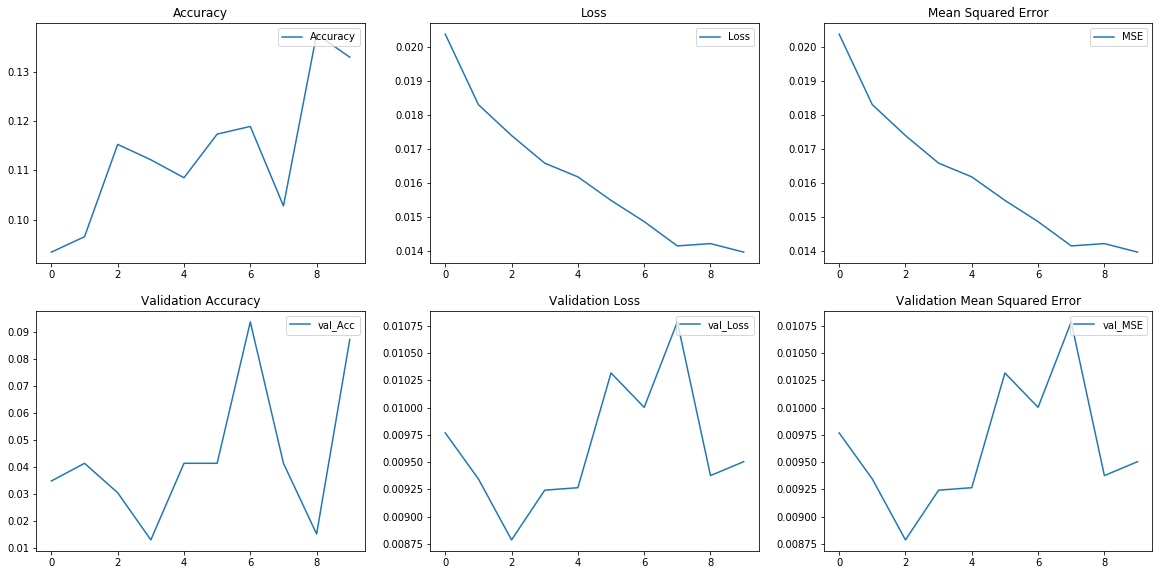

In [41]:
plt.figure(figsize=(20,15))
plt.subplot(331)
plt.plot(model_history.history['acc'] , label = 'Accuracy')
plt.legend(loc = 'upper right')
plt.title("Accuracy")

plt.subplot(332)
plt.plot(model_history.history['loss'] , label = 'Loss')
plt.legend(loc = 'upper right')
plt.title("Loss")

plt.subplot(333)
plt.plot(model_history.history['mean_squared_error'] , label = 'MSE')
plt.legend(loc = 'upper right')
plt.title("Mean Squared Error")

plt.subplot(334)
plt.plot(model_history.history['val_acc'] , label = 'val_Acc')
plt.legend(loc = 'upper right')
plt.title("Validation Accuracy")

plt.subplot(335)
plt.plot(model_history.history['val_loss'] , label = 'val_Loss')
plt.legend(loc = 'upper right')
plt.title("Validation Loss")

plt.subplot(336)
plt.plot(model_history.history['val_mean_squared_error'] , label = 'val_MSE')
plt.legend(loc = 'upper right')
plt.title("Validation Mean Squared Error")

plt.show()

In [42]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [43]:
X_test.shape

(459, 30, 36)

In [44]:
Y_train[:,0].shape

(1926,)

In [45]:
testPredict + 1

array([[ 0.92579234,  1.05035412,  0.90808463, ...,  1.02632487,
         0.96165252,  1.00874162],
       [ 0.92433566,  1.0500375 ,  0.90708983, ...,  1.0258677 ,
         0.960949  ,  1.0091536 ],
       [ 0.9233287 ,  1.04951835,  0.90640217, ...,  1.02493489,
         0.96020007,  1.00949645],
       ..., 
       [ 1.03204536,  1.04165614,  0.99891257, ...,  0.98739016,
         1.0348866 ,  0.99611908],
       [ 1.03199923,  1.04205227,  0.99896902, ...,  0.9877544 ,
         1.03487229,  0.99589509],
       [ 1.00329351,  1.02367055,  0.99690956, ...,  0.99496633,
         1.01074517,  1.02694154]], dtype=float32)

In [46]:
Y_test.shape

(459, 36)

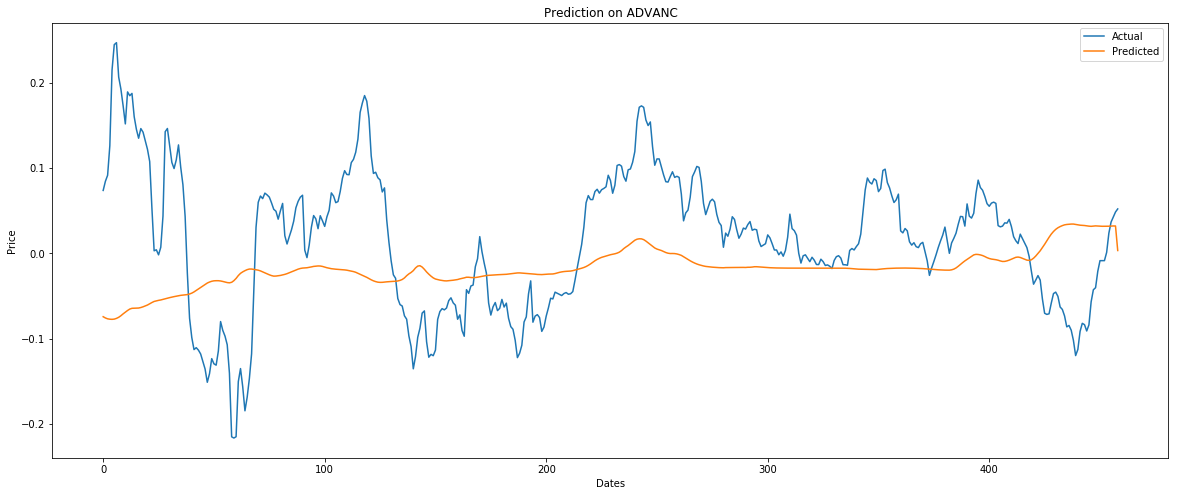

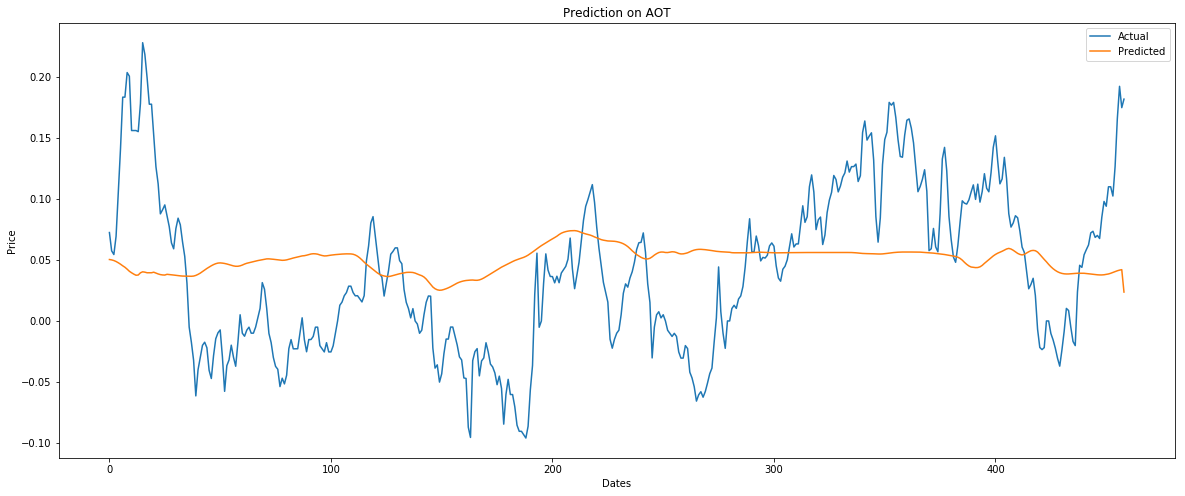

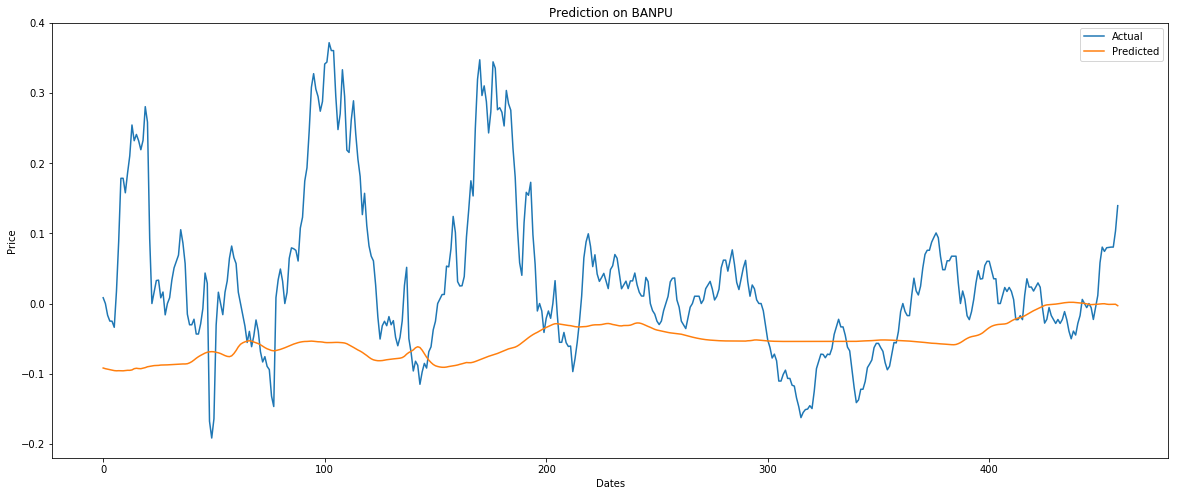

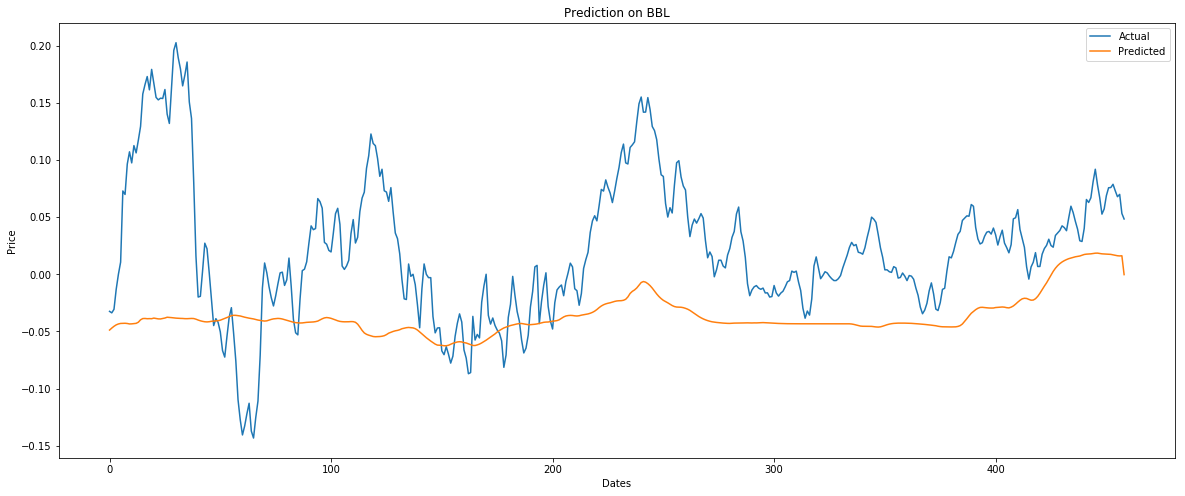

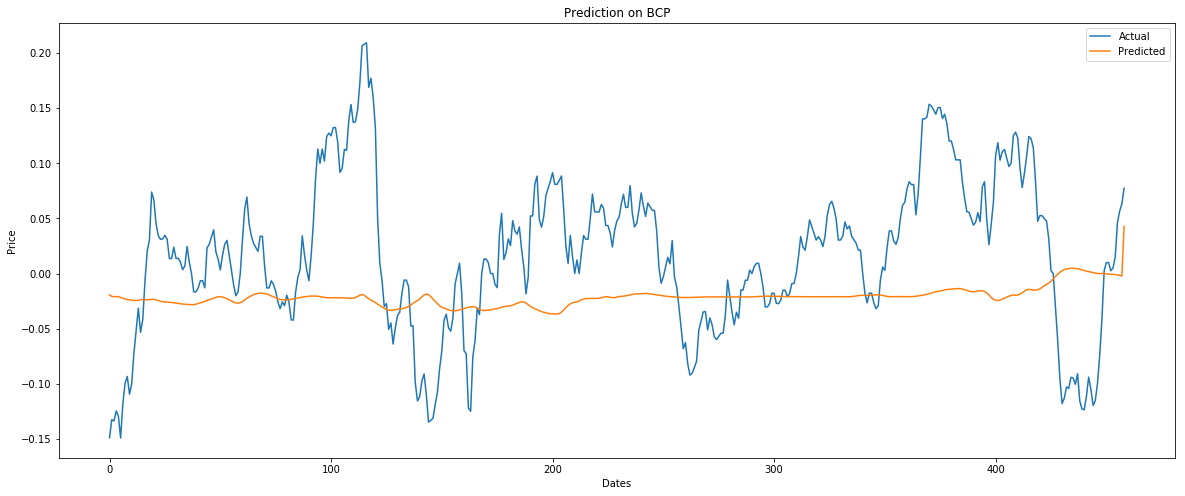

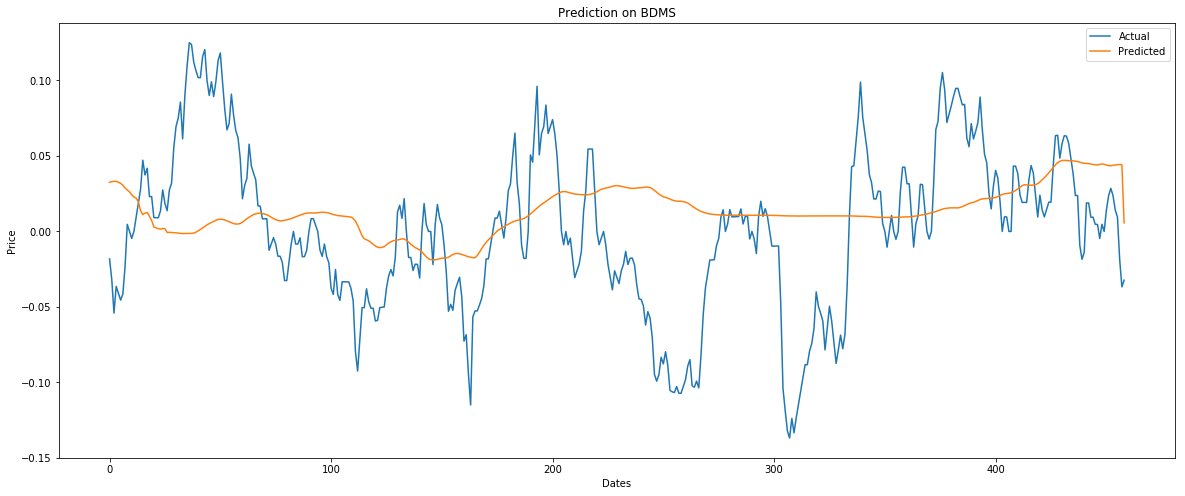

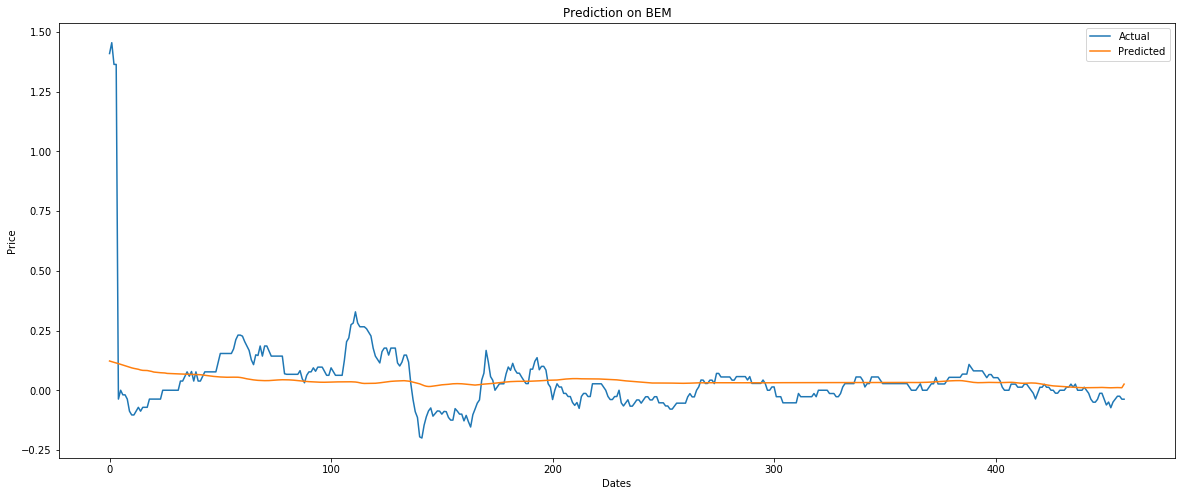

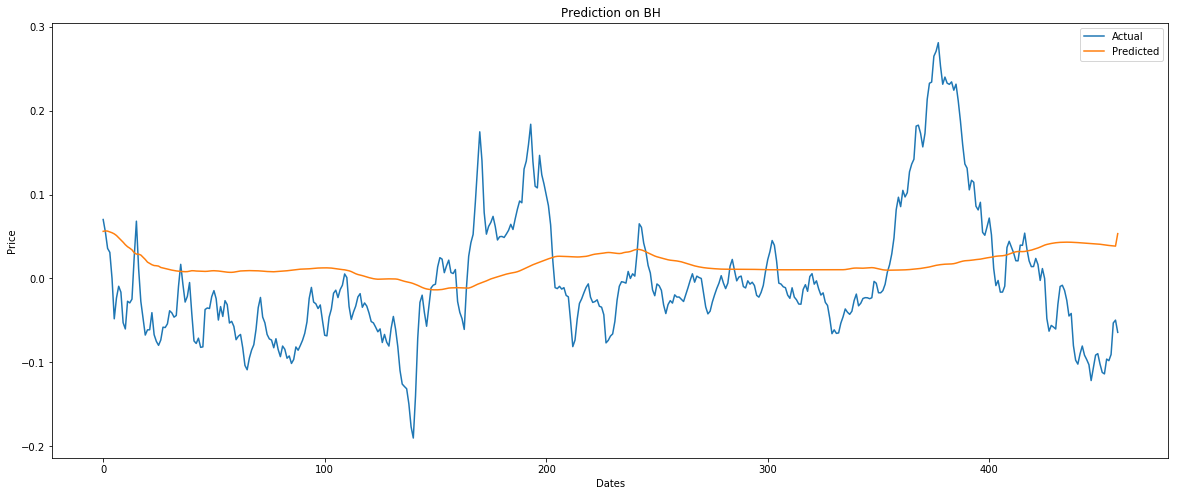

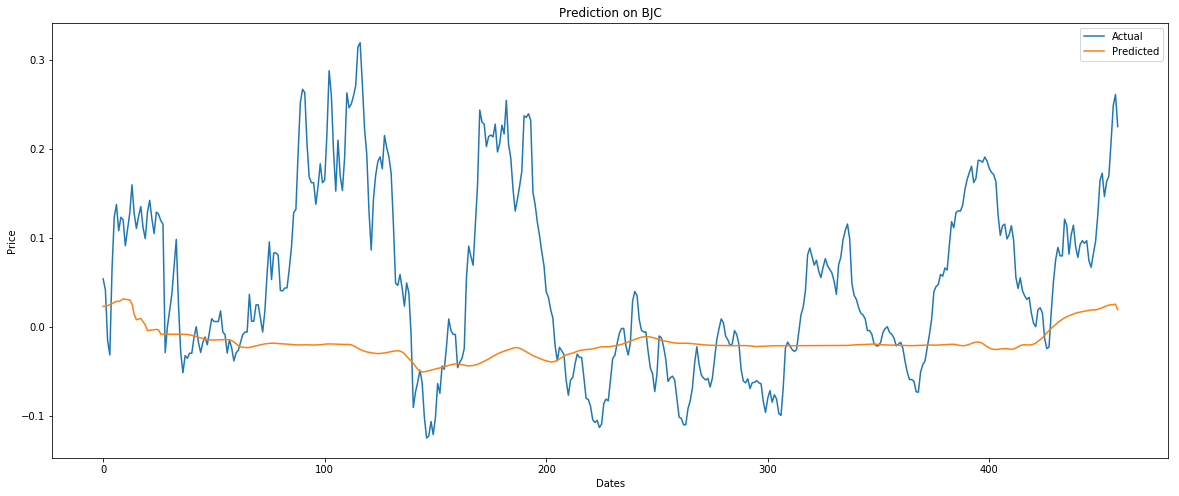

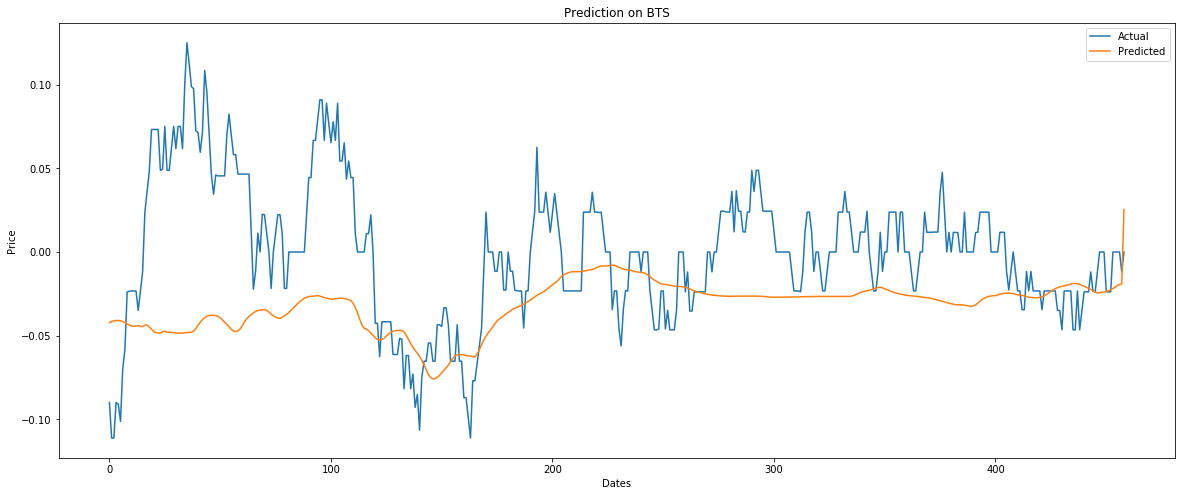

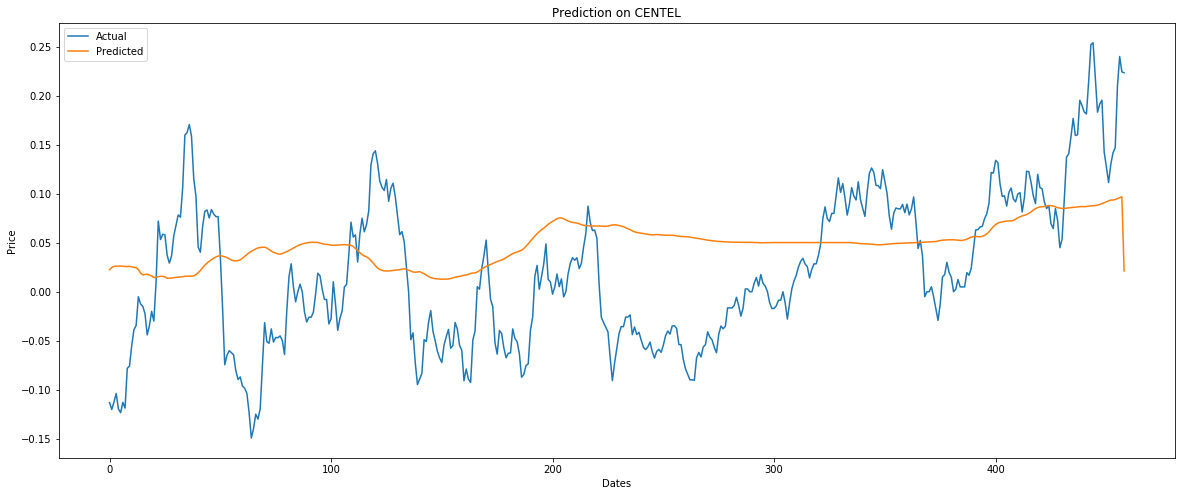

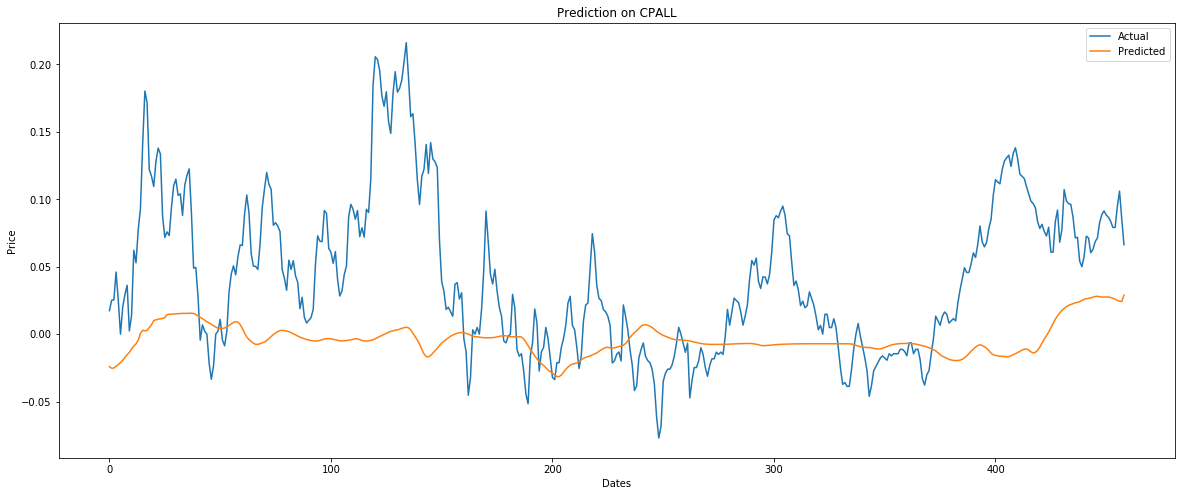

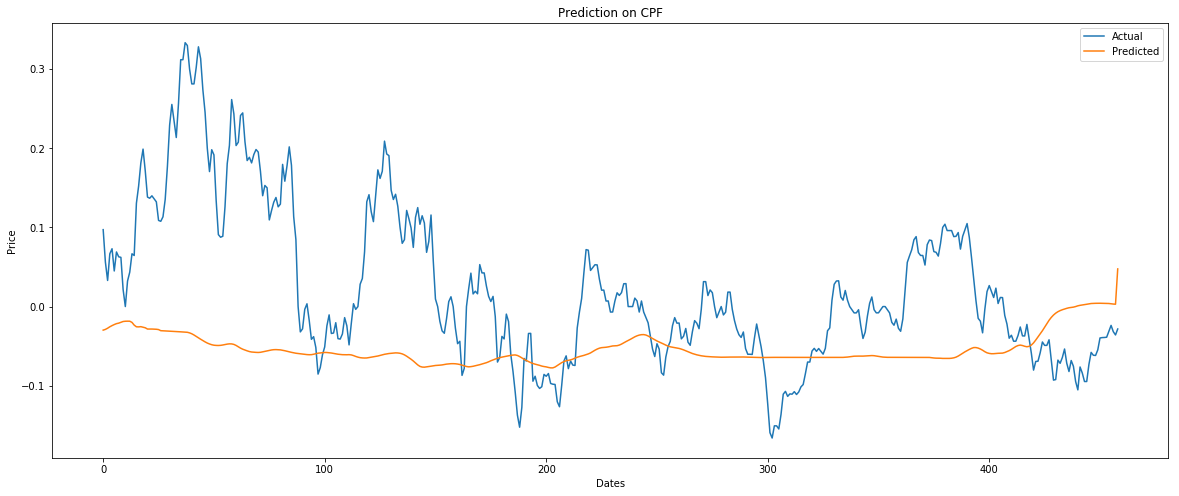

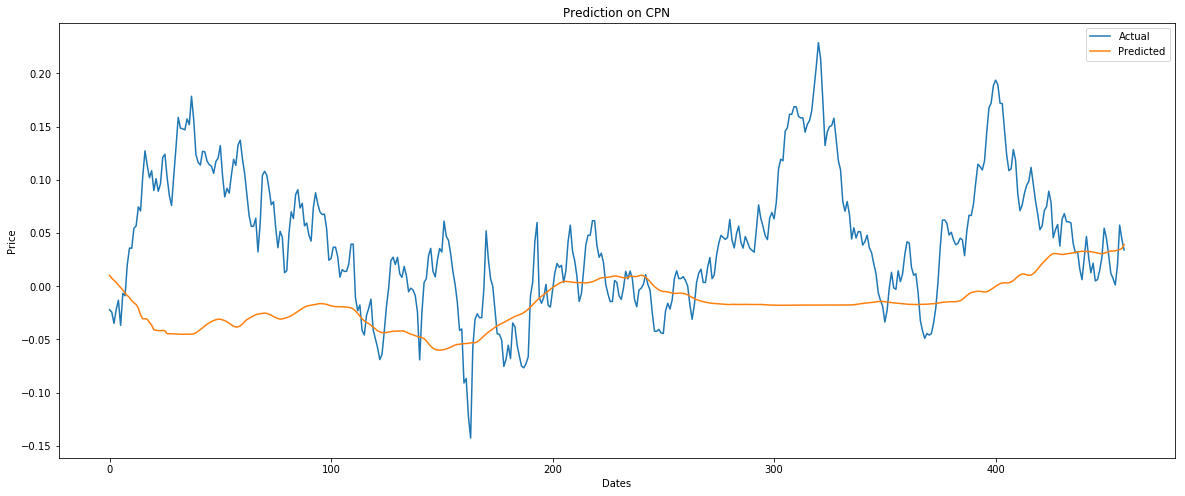

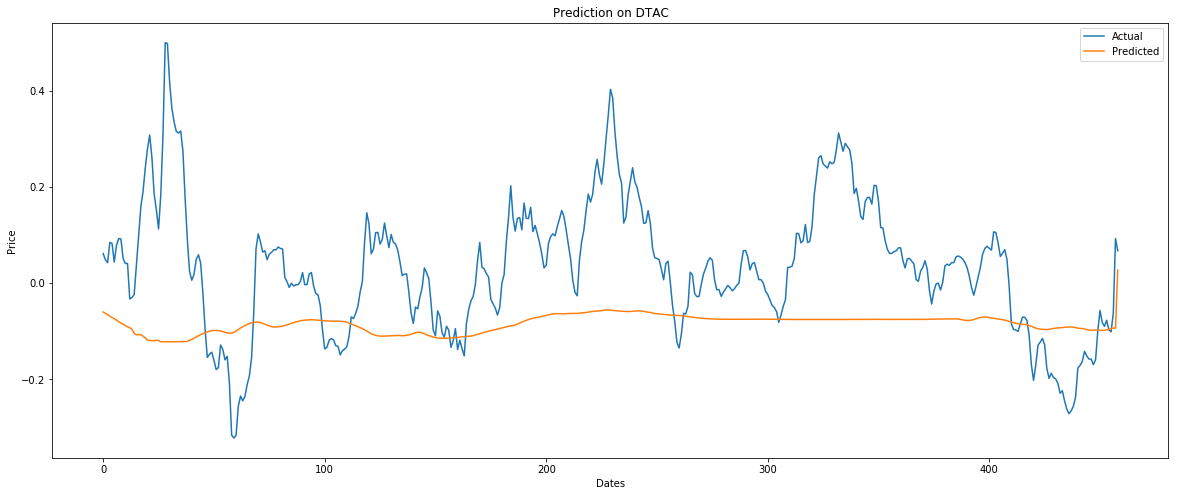

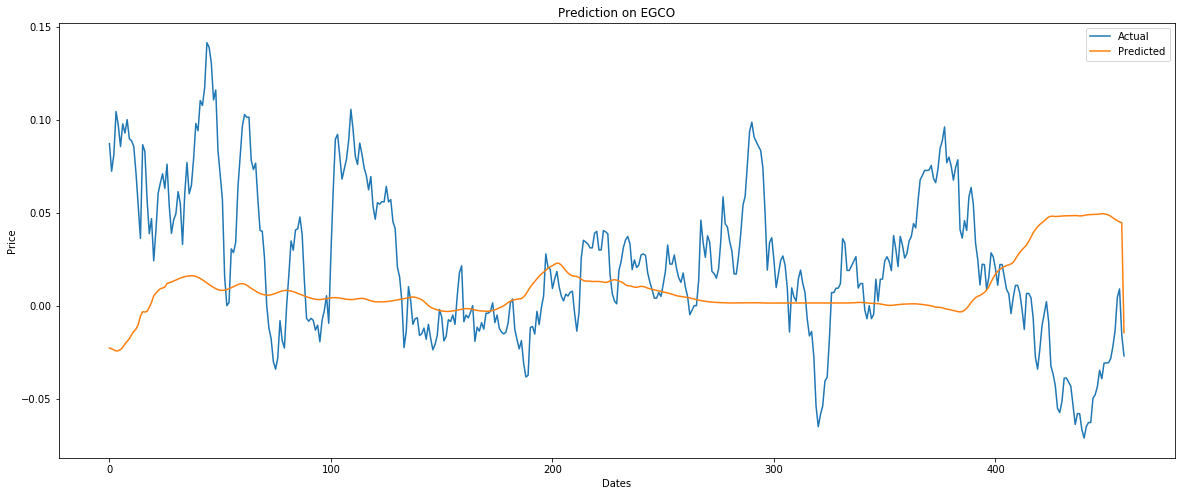

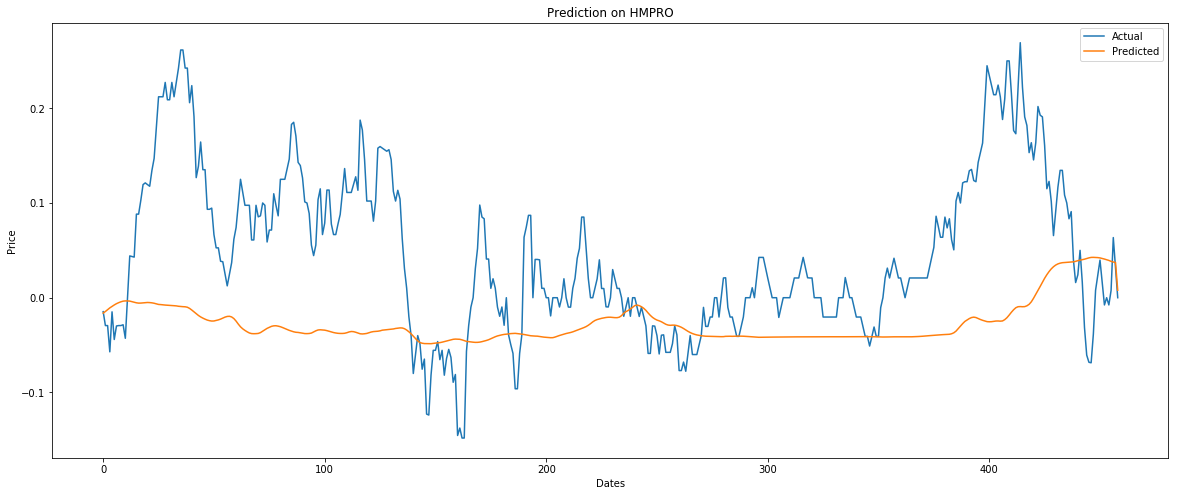

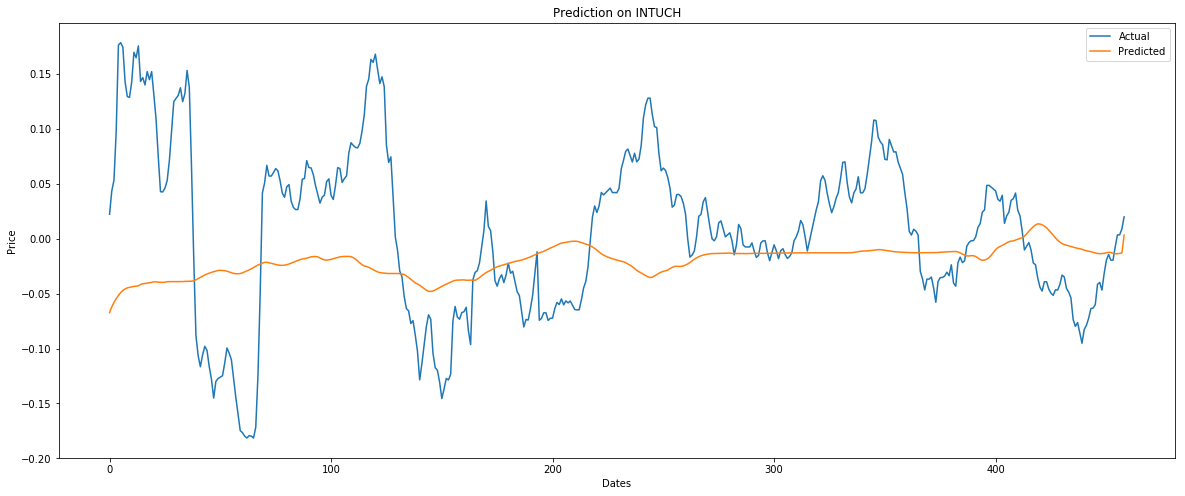

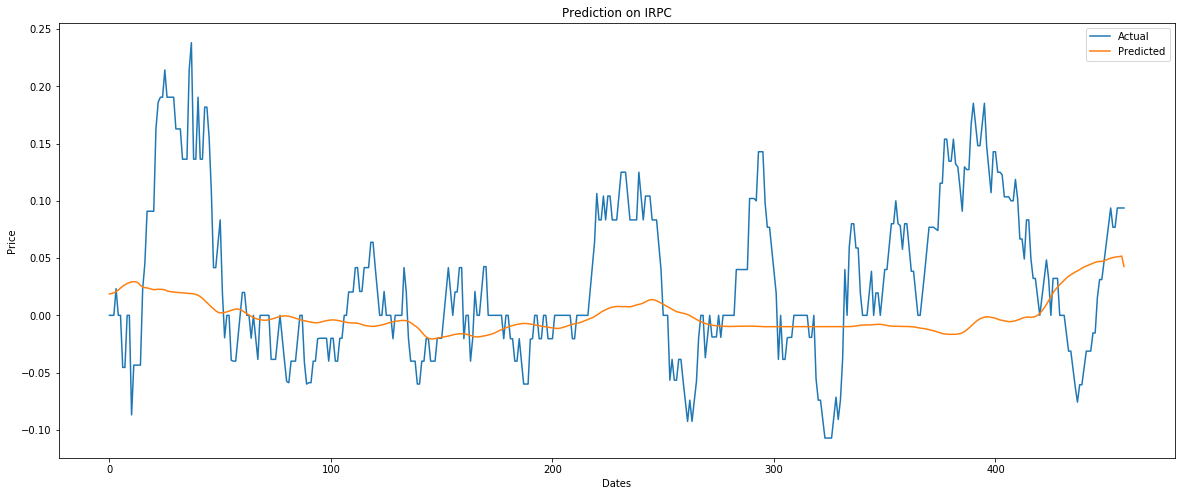

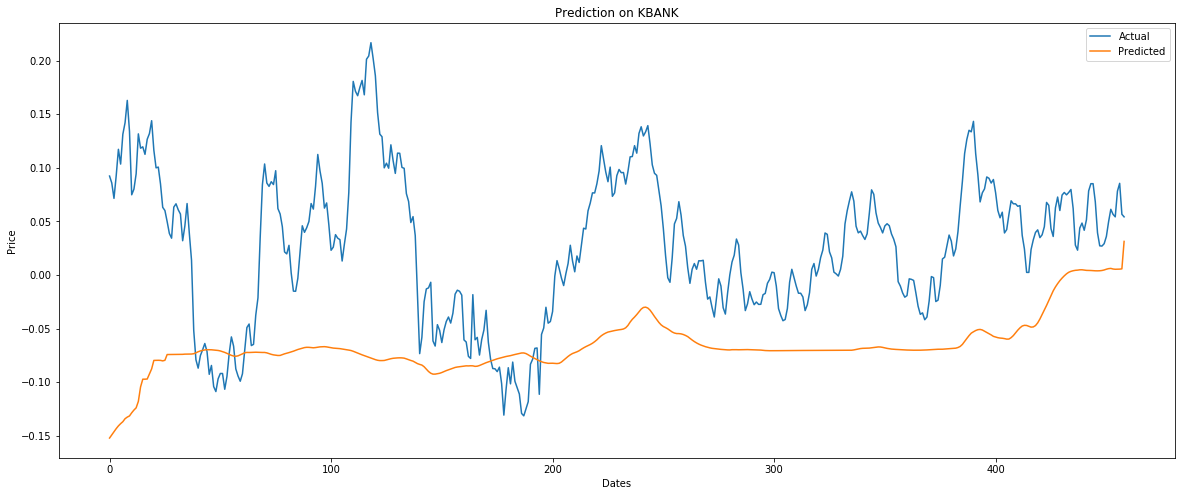

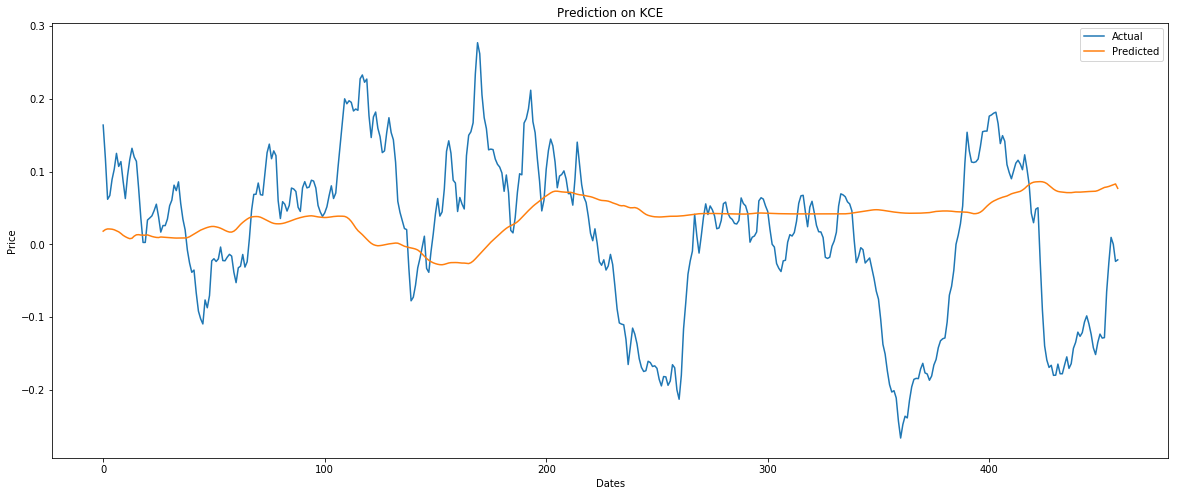

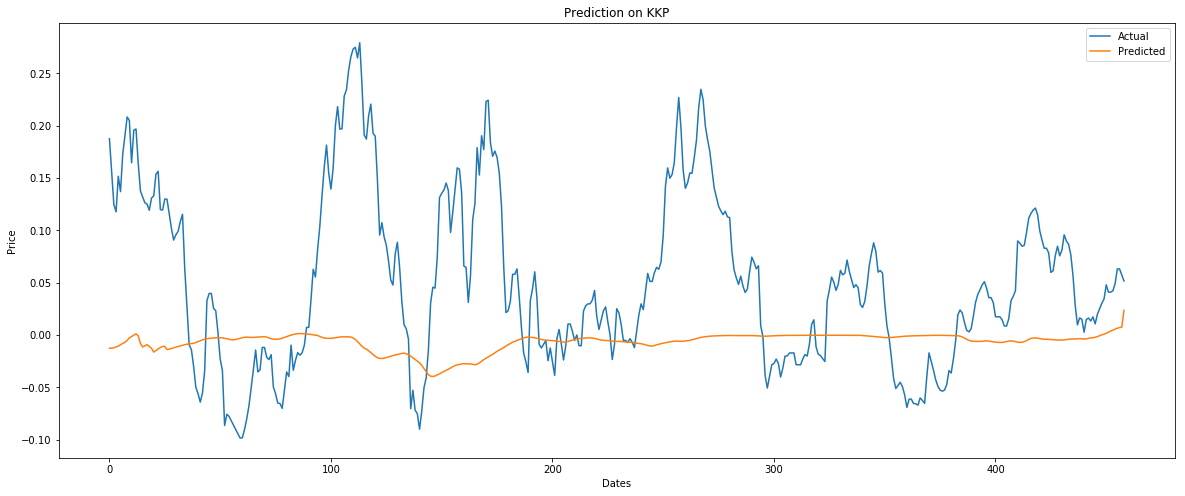

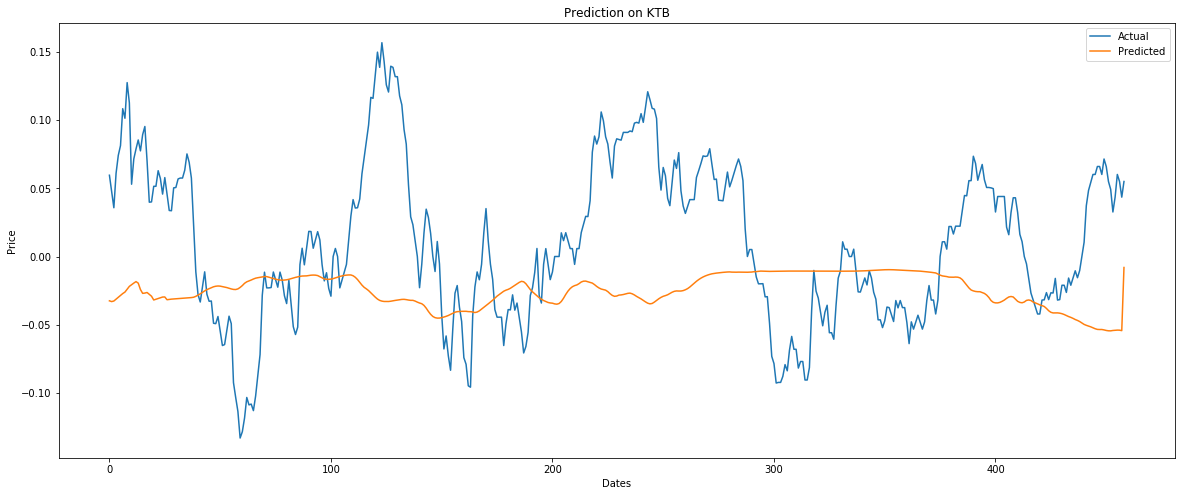

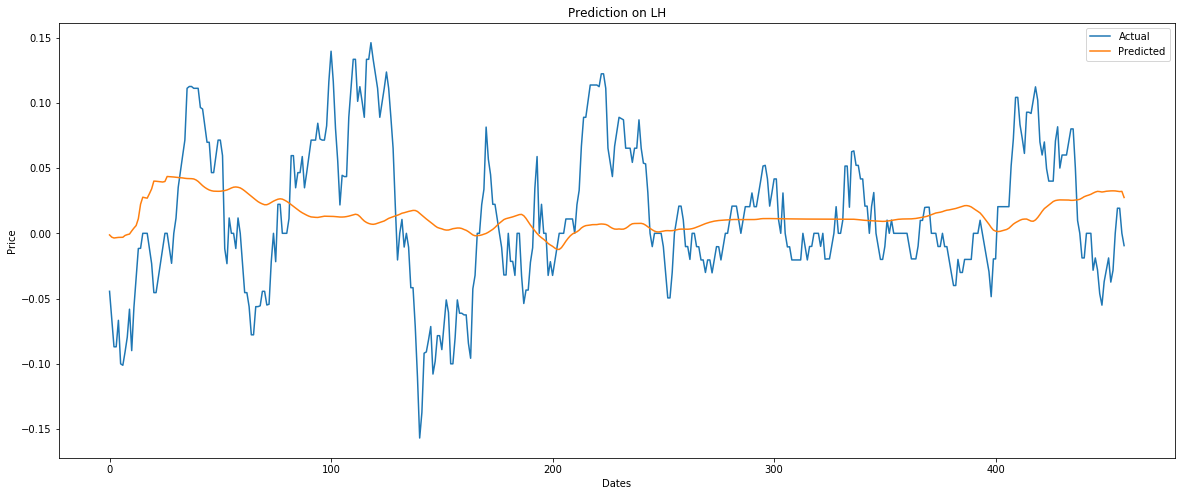

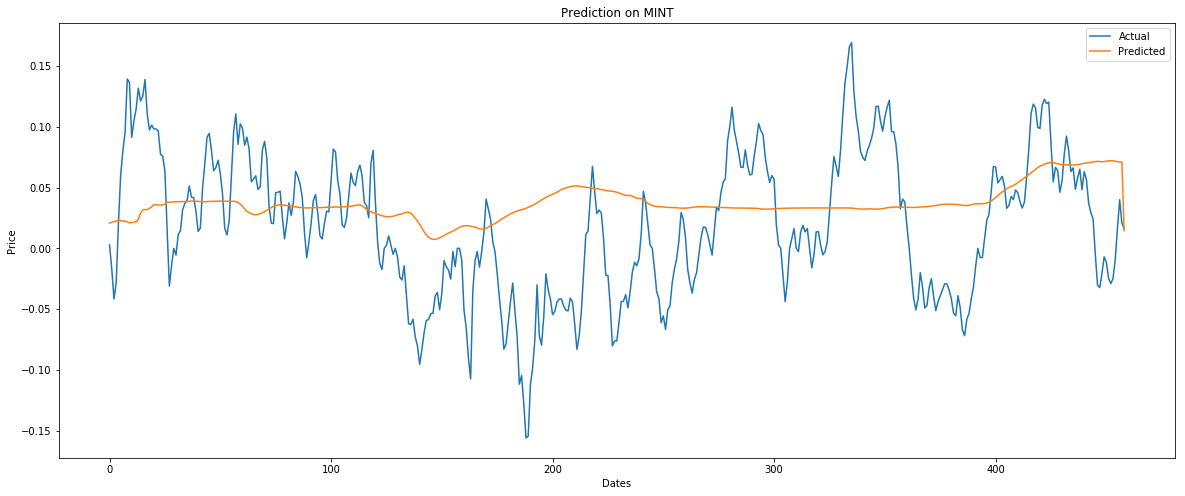

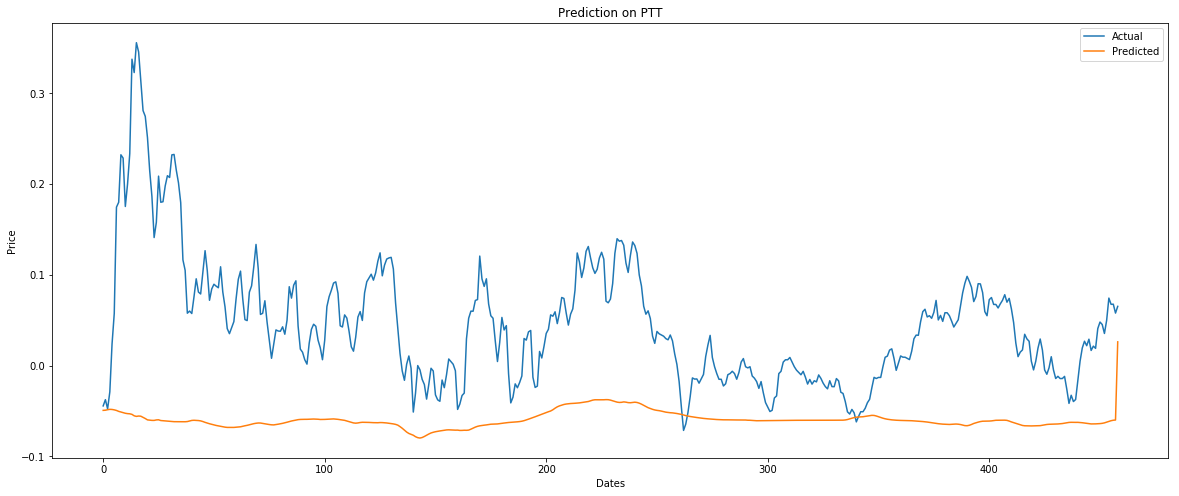

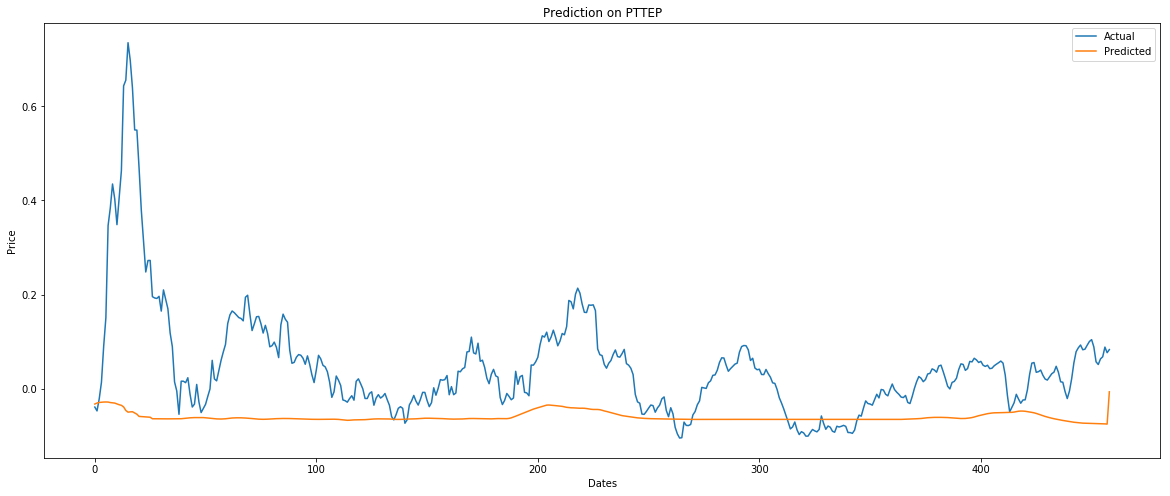

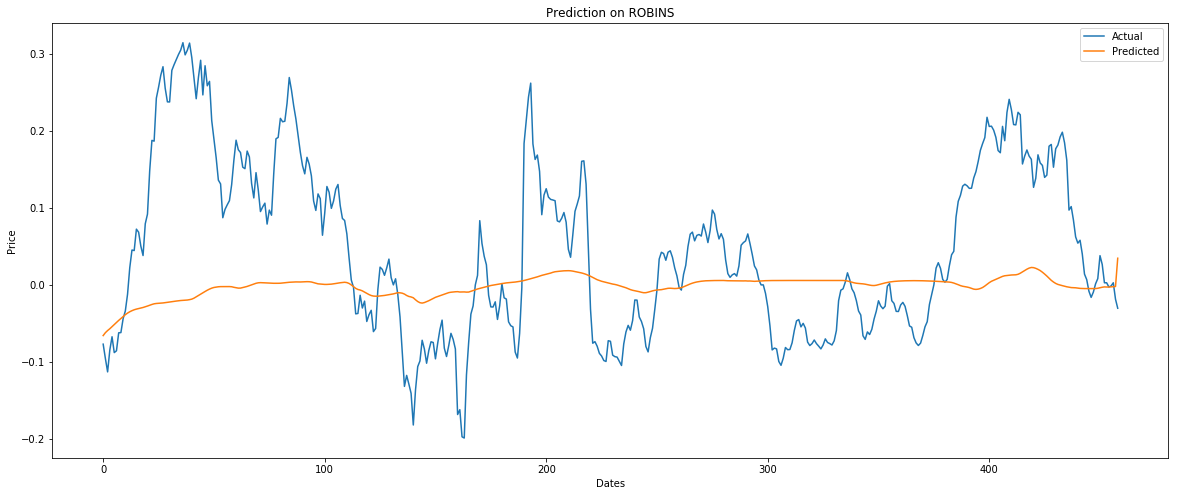

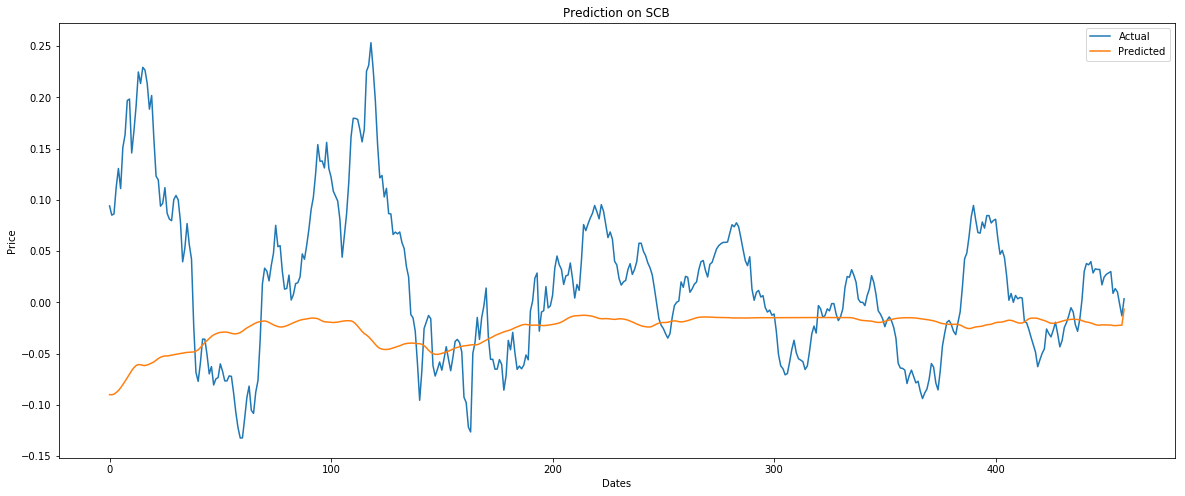

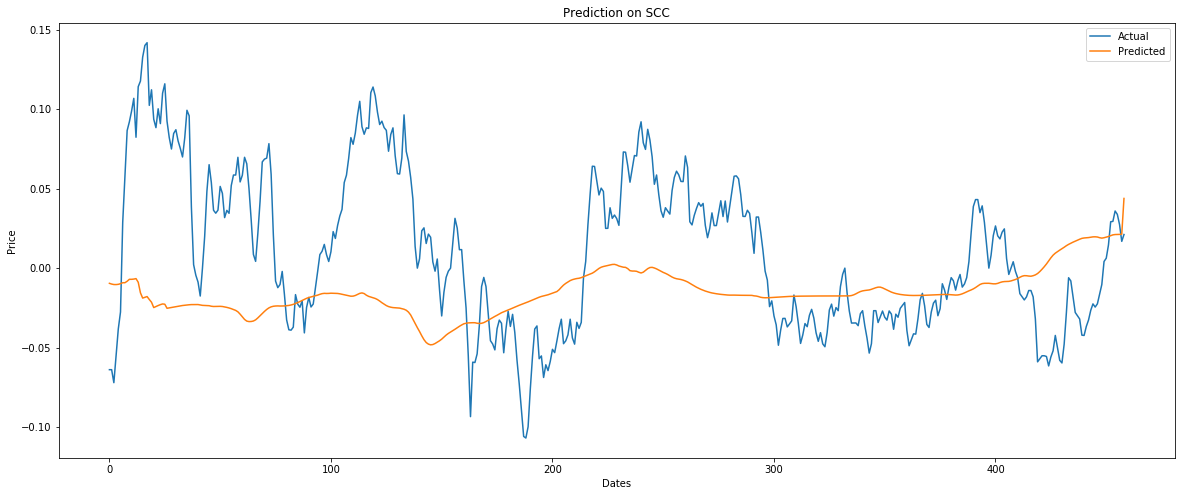

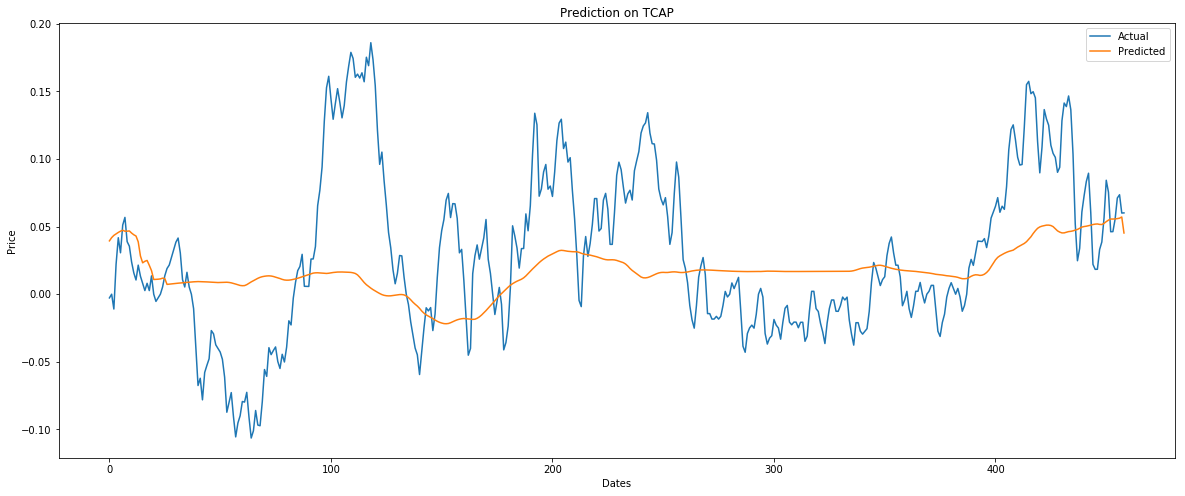

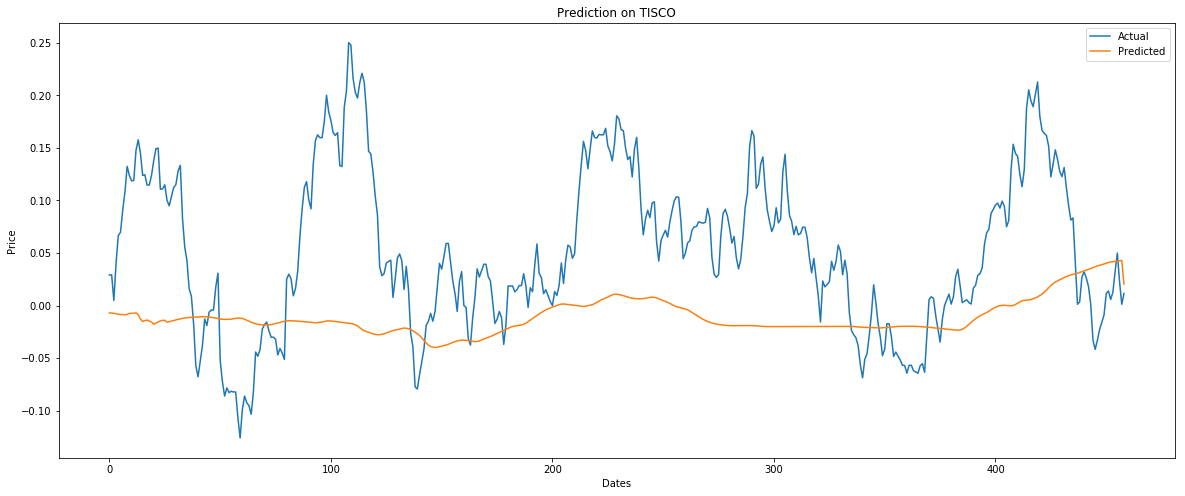

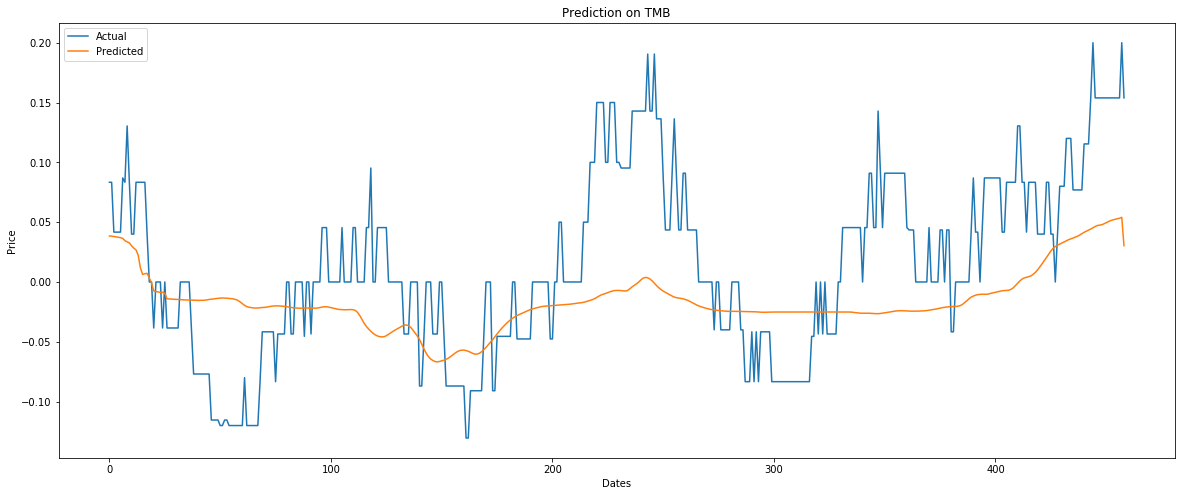

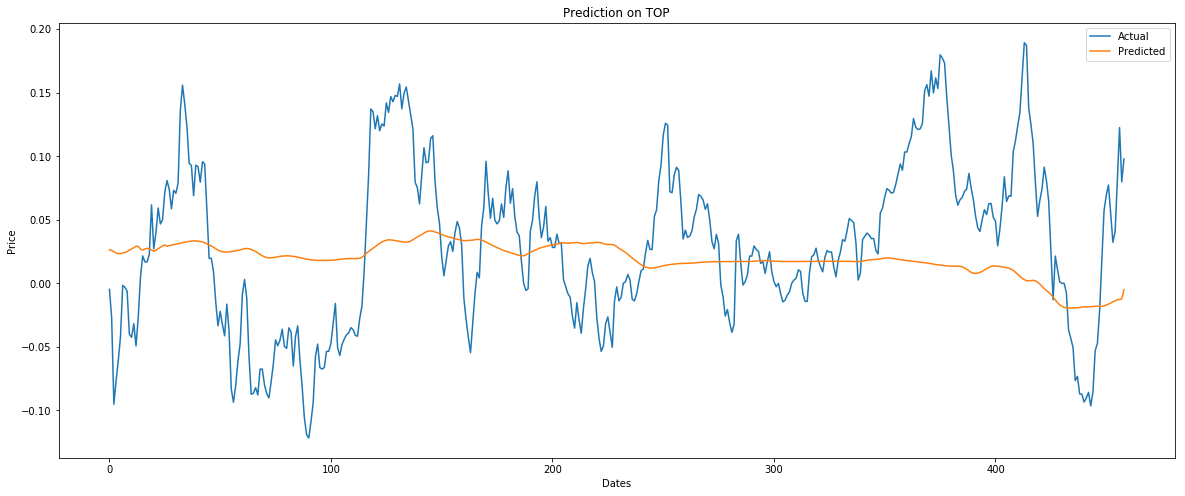

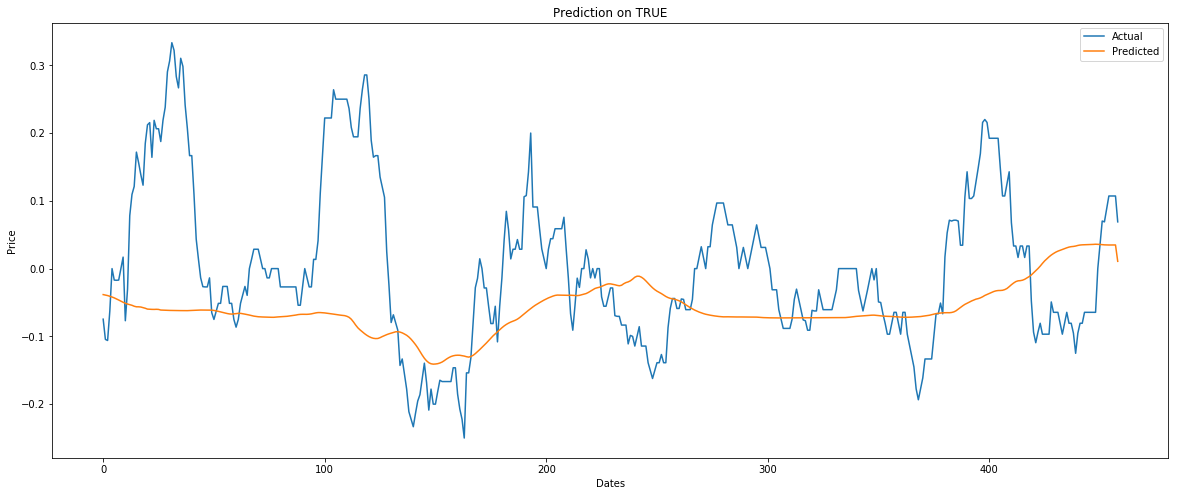

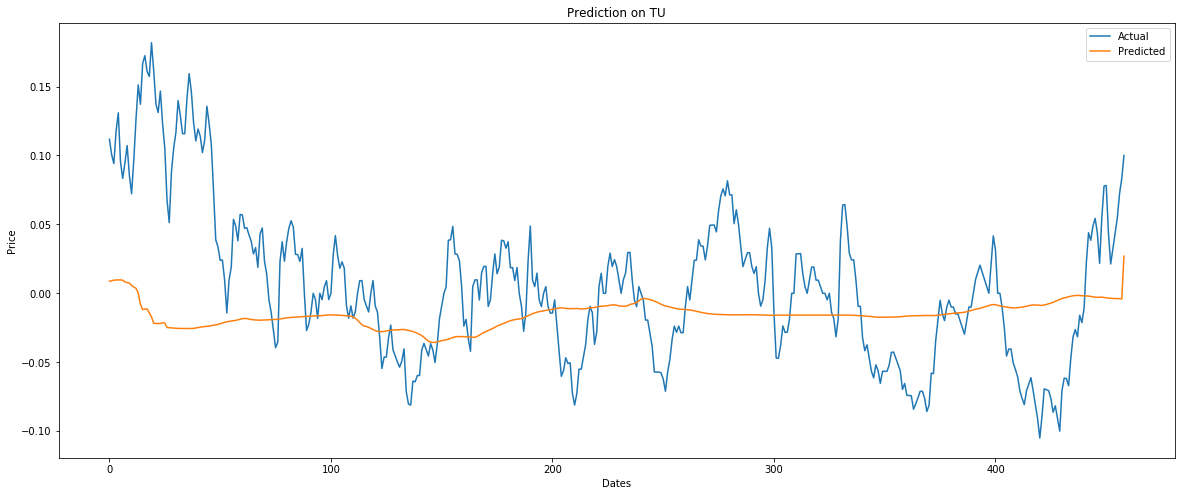

In [49]:
# plt.subplot(312)
# plt.plot(Y_train[:,1])
# plt.plot(trainPredict[:,1])
# plt.xlabel('Dates')
# plt.ylabel('Price')
# plt.title('Prediction on Training Set')
# plt.legend(['Actual','Predicted'])

# plt.subplot(313)
for index, value in enumerate(SET50):
    plt.figure(figsize=(20, 8))
    plt.plot(Y_test[:,index])
    plt.plot(testPredict[:,index])
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title('Prediction on ' + value)
    plt.legend(['Actual','Predicted'])
    plt.show()

